In [25]:
import pickle, os
import numpy as np
import scvelo as scv
import pandas as pd
import anndata as ad
import torch
from veloproj import *
import scanpy as sc

SEED = 2024
np.random.seed(SEED)

In [2]:
parser = get_parser()
args = parser.parse_args(args=['--lr',  '1e-5',
                               '--n-epochs', '20000', 
                               '--g-rep-dim', '100',
                               '--k-dim', '100',
                               #'--data-dir', '/data/groups/yhhuang/cqiao/Melania/adata_umap_pca.h5',
                               #'--model-name', 'Melania_Erythroid_mouse_model.cpt',
                               #'--exp-name', 'CohAE_Melania_Erythroid_mouse',
                               '--model-name', 'celldancer_simulation_mono.cpt',
                               '--exp-name', 'celldancer_simulation_mono',
                               '--device', 'cuda:0',
                               '--gumbsoft_tau', '1',
                               '--nb_g_src', "SU",
                               '--ld_nb_g_src', "X",
                               '--n_raw_gene', '2000',
                               '--n_conn_nb', '30',
                               '--n_nb_newadata', '30',
                               '--aux_weight', '1',
                               '--fit_offset_train', 'false',
                               '--fit_offset_pred', 'true',
                               '--use_offset_pred', 'false',
                               '--gnn_layer', 'GAT',
                               '--vis-key', 'X_umap',
                               '--vis_type_col', 'cell_type',
                               '--scv_n_jobs', '10',
                              ])

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device(args.device if args.device.startswith('cuda') and torch.cuda.is_available() else "cpu")

In [3]:
adata = ad.read_h5ad("/media/liyaru/LYR/Diff_change/8_dynamo_Data/scNT_HSC_scvelo_process.h5ad")
print(adata)
scv.tl.velocity(adata, mode='stochastic')

AnnData object with n_obs × n_vars = 1947 × 2000
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'velocyto_SVR'
    obsm: 'X_pca', 'X_umap', 'scNT_velocity_umap', 'velocity_umap'
    layers: 'M_n', 'M_nn', 'M_s', 'M_ss', 'M_t', 'M_tn', 'M_tt', 'M_u', 'M_us', 'M_uu',

In [4]:
def main_AE(args, adata):
    spliced = adata.layers['Ms']
    unspliced = adata.layers['Mu']
    tensor_s = torch.FloatTensor(spliced).to(device)
    tensor_u = torch.FloatTensor(unspliced).to(device)
    tensor_x = torch.FloatTensor(adata.X.toarray()).to(device)
    tensor_v = torch.FloatTensor(adata.layers['velocity']).to(device)

    model = init_model(adata, args, device)

    inputs = [tensor_s, tensor_u]
    xyids = [0, 1]
    if args.use_x:
        inputs.append(tensor_x)

    model = fit_model(args, adata, model, inputs, tensor_v, xyids, device)
    return tensor_s, tensor_u, tensor_x  

Loss: (Total) 0.255904, (AE) 0.255495, (LR) 1.00 * 0.000409: 100%|██████████| 20000/20000 [2:05:15<00:00,  2.66it/s]  


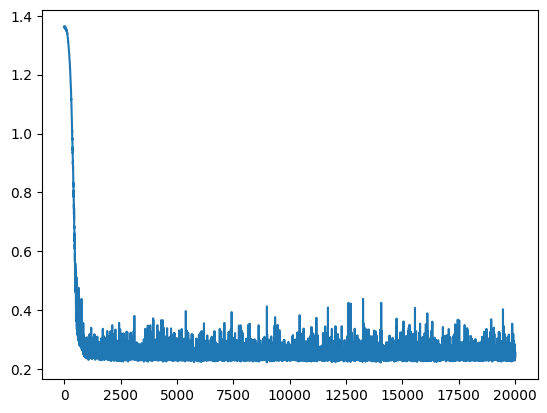

In [5]:
tensor_s, tensor_u, tensor_x = main_AE(args, adata)

In [6]:
model = init_model(adata, args, device)
model.load_state_dict(torch.load(args.model_name))
model = model.to(device)
model.eval()
with torch.no_grad():
    x = model.encoder(tensor_x)
    s = model.encoder(tensor_s)
    u = model.encoder(tensor_u)
    
    v = estimate_ld_velocity(s, u, device=device, perc=[5, 95], 
                                norm=args.use_norm, fit_offset=args.fit_offset_pred, 
                                use_offset=args.use_offset_pred).cpu().numpy()
    x = x.cpu().numpy()
    s = s.cpu().numpy()
    u = u.cpu().numpy()


In [31]:
adata_new = new_adata(adata, 
                  x, s, u, v, 
                  g_basis=args.ld_nb_g_src, 
                  n_nb_newadata=args.n_nb_newadata,
                  X_emb_key='X_umap')


In [34]:
print(adata)

AnnData object with n_obs × n_vars = 1947 × 2000
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'gene_name_mapping', 'query', 'scopes', '_id', '_score', 'symbol', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'PCs', 'batch_colors', 'cell_type_colors', 'dynamics', 'explained_variance_ratio_', 'feature_selection', 'genes_to_use', 'grid_velocity_umap', 'neighbors', 'pca_mean', 'pp', 'velocyto_SVR', 'velocity_params'
    obsm: 'X_pca', 'X_umap', 'scNT_velocity_umap', 'velocity_

In [38]:
adata_new.obsm['scNT_velocity_umap'] = adata.obsm['scNT_velocity_umap']
print(adata_new)
adata_new.write_h5ad("adata/veloAE.h5ad")

AnnData object with n_obs × n_vars = 1947 × 100
    obs: 'batch', 'cell_type', 'time', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'total_Size_Factor', 'initial_total_cell_size', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'new_Size_Factor', 'initial_new_cell_size', 'ntr', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'new_velocity_self_transition'
    uns: 'neighbors', 'batch_colors', 'cell_type_colors', 'new_velocity_graph', 'new_velocity_graph_neg', 'new_velocity_params'
    obsm: 'X_pca', 'X_umap', 'new_velocity_umap', 'scNT_velocity_umap'
    layers: 'spliced', 'unspliced', 'new_velocity', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'


  0%|          | 0/1947 [00:00<?, ?cells/s]

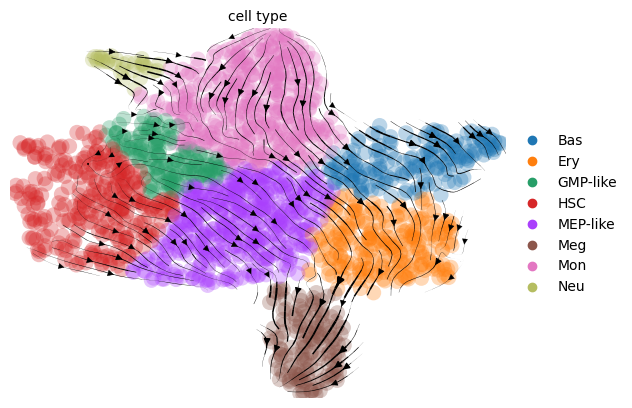

In [39]:
scv.tl.velocity_graph(adata_new,vkey='new_velocity',n_jobs=10,basis= "umap")
scv.pl.velocity_embedding_stream(adata_new,basis= "umap",color="cell_type",
                                 vkey='new_velocity',
                                 palette = sc.pl.palettes.default_20,
                                 legend_loc = 'right margin',
                                 save="Figure/stream/" + "veloAE.svg" )